In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist2, plot_graphs
import numpy as np
import seaborn as sns

sns.set()

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
pin_memory = torch.cuda.is_available()
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.6.0  Device: cuda


In [3]:
train_loader, valid_loader, test_loader = mnist2(batch_size=64, valid=10000, pin_memory=True, num_workers=2)

In [4]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        w = 128 * 10
        self.fc1 = nn.Linear(28*28, w)
        self.fc2 = nn.Linear(w, w)
        self.fc3 = nn.Linear(w, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(w)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        
#         data = data.to(device)
#         target = target.to(device)
        pin_memory = False
        data, target = data.cuda(non_blocking=pin_memory), target.cuda(non_blocking=pin_memory)
    
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [6]:
models = {'default': Net(False, False).to(device), 'bn': Net(True, False).to(device), 'drop': Net(False, True).to(device), 'both': Net(True, True).to(device)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
#             data = data.to(device)
#             target = target.to(device)
            data, target = data.cuda(non_blocking=pin_memory), target.cuda(non_blocking=pin_memory)
        
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [8]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses default: 2.303749 bn: 2.322037 drop: 2.319606 both: 2.417658
Train Epoch: 1 [12800/50000 (26%)]	Losses default: 0.390970 bn: 0.441010 drop: 0.407020 both: 0.482237
Train Epoch: 1 [25600/50000 (51%)]	Losses default: 0.400083 bn: 0.312547 drop: 0.413433 both: 0.382156
Train Epoch: 1 [38400/50000 (77%)]	Losses default: 0.269310 bn: 0.186368 drop: 0.288064 both: 0.207117
Train Epoch: 1 [12512/50000 (100%)]	Losses default: 0.257826 bn: 0.095056 drop: 0.274531 both: 0.183830
Test set:
default: Loss: 0.2249	Accuracy: 9338.0/10000 (93%)
bn: Loss: 0.1405	Accuracy: 9621.0/10000 (96%)
drop: Loss: 0.2473	Accuracy: 9272.0/10000 (93%)
both: Loss: 0.1691	Accuracy: 9538.0/10000 (95%)

Train Epoch: 2 [0/50000 (0%)]	Losses default: 0.315628 bn: 0.187713 drop: 0.360515 both: 0.250673
Train Epoch: 2 [12800/50000 (26%)]	Losses default: 0.105928 bn: 0.068206 drop: 0.120999 both: 0.076671
Train Epoch: 2 [25600/50000 (51%)]	Losses default: 0.097638 bn: 0.049807 drop: 0.124

In [ ]:
plot_graphs(test_log, 'loss')

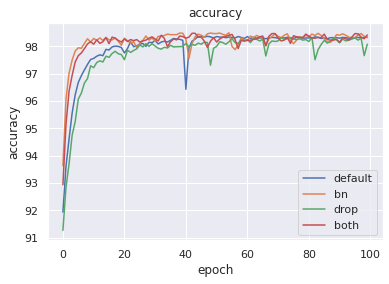

In [18]:
plot_graphs(test_log, 'accuracy')

In [15]:
test_log['default'][0]

(0.3261975348234177, 90.94)

In [16]:
plot_graphs(train_log, 'loss')

IndexError: list index out of range

In [16]:
train_log['default'][0]

IndexError: list index out of range